# House prices prediction (kaggle.com)
In the Ames Housing dataset on kaggle, we would like to predict house prices with regression models. Thanks to @Serigne on kaggle.com for some helpful hints. 

1. [Import and explore the data](#sec_import)<br>
2. [Clean, fill in the missing data, and remove outliers](#sec_clean)<br>
 2.1 [Fill in the missing data](#sec_fill_missing)<br>
 2.2 [Convert to numeric values or dummies](#sec_convert_to_numeric_or_dummies)<br>
     2.2.1 [Convert categorial features to dummies](#sec_convert_to_dummies)<br>
     2.2.2 [Convert categorial features to numeric values](#sec_convert_to_numeric)<br>


### Import Libraries

In [1]:
import pandas as pd
from sklearn import model_selection, linear_model, ensemble, metrics
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
import xgboost as xgb
from sklearn.base import clone
from sklearn.kernel_ridge import KernelRidge
from scipy.stats import skew

<a id = 'sec_import'></a>
## 1. Import and explore the data 

In [2]:
trData = pd.read_csv('train.csv')
testData = pd.read_csv('test.csv')
data_list = [trData, testData]
ltr = len(trData)
ltest = len(testData)

In [3]:
print("The size of the training data is {}.".format(trData.shape))
print("The size of the test data is {}.".format(testData.shape))

The size of the training data is (1460, 81).
The size of the test data is (1459, 80).


The test and train data have almost the same number of samples (~1460)! 

In [4]:
trData.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
trData.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000,1460.000,1201.000,1460.000,1460.000,1460.000,1460.000,1460.000,1452.000,1460.000,...,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000
mean,730.500,56.897,70.050,10516.828,6.099,5.575,1971.268,1984.866,103.685,443.640,...,94.245,46.660,21.954,3.410,15.061,2.759,43.489,6.322,2007.816,180921.196
std,421.610,42.301,24.285,9981.265,1.383,1.113,30.203,20.645,181.066,456.098,...,125.339,66.256,61.119,29.317,55.757,40.177,496.123,2.704,1.328,79442.503
min,1.000,20.000,21.000,1300.000,1.000,1.000,1872.000,1950.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,2006.000,34900.000
25%,365.750,20.000,59.000,7553.500,5.000,5.000,1954.000,1967.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,2007.000,129975.000
50%,730.500,50.000,69.000,9478.500,6.000,5.000,1973.000,1994.000,0.000,383.500,...,0.000,25.000,0.000,0.000,0.000,0.000,0.000,6.000,2008.000,163000.000
75%,1095.250,70.000,80.000,11601.500,7.000,6.000,2000.000,2004.000,166.000,712.250,...,168.000,68.000,0.000,0.000,0.000,0.000,0.000,8.000,2009.000,214000.000
max,1460.000,190.000,313.000,215245.000,10.000,9.000,2010.000,2010.000,1600.000,5644.000,...,857.000,547.000,552.000,508.000,480.000,738.000,15500.000,12.000,2010.000,755000.000


<a id = 'sec_clean'> </a>
## 2. Clean, fill in the missing data, and remove outliers

What are the missing data? 

In [6]:
trData.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [7]:
nullCounts = trData.isnull().sum()
nullCounts[nullCounts > 0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [8]:
nullCountsTest = testData.isnull().sum()
nullCountsTest[nullCountsTest > 0]

MSZoning           4
LotFrontage      227
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        16
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76
GarageYrBlt       78
GarageFinish      78
GarageCars         1
GarageArea         1
GarageQual        78
GarageCond        78
PoolQC          1456
Fence           1169
MiscFeature     1408
SaleType           1
dtype: int64

In [9]:
def CheckNull(df, feature):
    print(df[feature].isnull().sum())

<a id = 'sec_fill_missing'> </a>
### 2.1 Fill in the missing data
We fill in the missing data with either mean() or mode(). 

In [10]:
testData['TotalBsmtSF'].fillna(testData['TotalBsmtSF'].mean(), inplace = True)
testData['GarageArea'].fillna(testData['GarageArea'].mean(), inplace = True)
testData['MSZoning'].fillna(testData['MSZoning'].mode()[0], inplace = True)
testData['SaleType'].fillna(testData['SaleType'].mode()[0], inplace = True)
for data in data_list:
    data['LotFrontage'].fillna(data['LotFrontage'].mean(), inplace = True)
    data['BsmtQual'].fillna('None', inplace = True)
    data['Functional'].fillna(data['Functional'].mode()[0], inplace = True)
    data['GarageYrBlt'].fillna(data['GarageYrBlt'].mean(), inplace = True)
    data['GarageCars'].fillna(data['GarageCars'].mode()[0], inplace = True)
    data['Electrical'].fillna(data['Electrical'].mode()[0], inplace = True)
    data['MasVnrType'].fillna(data['MasVnrType'].mode()[0], inplace = True)
    data['MasVnrArea'].fillna(data['MasVnrArea'].mean(), inplace = True)
    data['BsmtCond'].fillna('None', inplace = True)
    data['BsmtExposure'].fillna('None', inplace = True)
    data['GarageType'].fillna('None', inplace = True)
    data['BsmtFinSF1'].fillna(data['BsmtFinSF1'].mean(), inplace = True)
    data['BsmtFinSF2'].fillna(data['BsmtFinSF2'].mean(), inplace = True)
    data['BsmtUnfSF'].fillna(data['BsmtUnfSF'].mean(), inplace = True)
    data['PoolQC'].fillna('None', inplace = True)
    data['MiscFeature'].fillna('None', inplace = True)
    data['Alley'].fillna('None', inplace = True)
    data['Fence'].fillna('None', inplace = True)
    data['BsmtFullBath'].fillna(0, inplace = True)
    data['BsmtHalfBath'].fillna(0, inplace = True)
    data['Exterior1st'].fillna(data['Exterior1st'].mode()[0], inplace = True)
    data['Exterior2nd'].fillna(data['Exterior2nd'].mode()[0], inplace = True)
    data['BsmtFinType2'].fillna('None', inplace = True)
    data['FireplaceQu'].fillna('None', inplace = True)
    data['GarageFinish'].fillna('None', inplace = True)
    data['KitchenQual'].fillna(data['KitchenQual'].mode()[0], inplace = True)
    data['Exterior1st'].fillna(data['Exterior1st'].mode()[0], inplace = True)
    data['Exterior2nd'].fillna(data['Exterior2nd'].mode()[0], inplace = True)
    data['BsmtFinType1'].fillna('None', inplace = True)
    data['GarageQual'].fillna('None', inplace = True)
    data['GarageCond'].fillna('None', inplace = True)
    data['Utilities'].fillna('None', inplace = True)

In [11]:
testData['BsmtExposure'].value_counts()

No      951
Av      197
Gd      142
Mn      125
None     44
Name: BsmtExposure, dtype: int64

In [12]:
testData['BsmtFullBath'].value_counts()

0.000    851
1.000    584
2.000     23
3.000      1
Name: BsmtFullBath, dtype: int64

In [13]:
for data in data_list:
#     data['GarageTypeSmple'] = data['GarageType']
#     data['GarageTypeSmple'] = data['GarageType'].replace(['Basment', 'CarPort', '2Types'], 'Rare')
#     data['ExterCondSmple'] = data['ExterCond'].replace(['Fa', 'Ex', 'Po'], 'Rare')
    data['HasDeckPorch'] = ((data['WoodDeckSF'] > 0) | (data['OpenPorchSF'] > 0) | (data['EnclosedPorch']) > 0 |
                            (data['3SsnPorch'] > 0) | (data['ScreenPorch'] > 0)) * 1
    data['HasPool'] = (data['PoolArea'] > 0) * 1
    data['HalfFullBath'] = data['FullBath'] + data['HalfBath']
#     data['SaleTypeSmple'] = data['SaleType'].replace(['CoD', 'ConLD', 'ConLw', 'ConLI', 'Oth', 'Con', 'CWD'], 'Rare')

In [14]:
trData['PricePerArea'] = trData['SalePrice'] / trData['GrLivArea']
trData['PricePerArea'].mean()

120.57287807326857

<a id = 'sec_convert_to_numeric_or_dummies'></a>
### 2.2 Convert to numeric
We now convert the non-numeric values to numeric values or dummies. The categorial type features will be converted to dummies and the rest of non-numeric features will be converted to numeric values accordingly. 

<a id = 'sec_convert_to_numeric'></a>
#### 2.2.1 Convert non-numeric, non-categorial to numeric
There are some featurs which are non-numeric but they is a relationship among their values. For instance, the ratings such as Poor, Good, Excellent. For these types of features, we manually set the numeric values in an ascending or descending order. 

The following variables are non-numeric but also can be regarded as non-categorial:

LandContour, Utilities, LandSlope, OverallQual, OverallCond, ExterQual, ExterCond, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, HeatingQC, KitchenQual, Functional, FireplaceQu, GarageFinish, GarageQual, GarageCond, PavedDrive, PoolQC, Fence

In [15]:
def PlotCorr(df, feature):
    sns.barplot(x = df[feature], y = df['SalePrice'])
    print(df[feature].value_counts())
def PlotCorr2(df, feature):
    sns.barplot(x = df[feature], y = df['PricePerArea'])
    print(df[feature].value_counts())

**LandContour**:

Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64


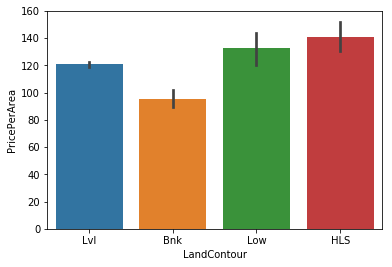

In [16]:
PlotCorr2(trData, 'LandContour')

We expected that a Level countour be more expensive, but it does not seem to be the case on average. We decide to drop this feature as it does not seem meaningfull in relation to the saleprice. 

In [17]:
def combineTrTest(dfTr, dfTest):
    dfCombined = pd.concat(objs=[dfTr, dfTest], axis = 0).reset_index(drop = True)
    return(dfCombined)

In [18]:
combinedData = combineTrTest(trData, testData)
combinedData['LandContour'].replace(['Lvl', 'Low', 'HLS'],['Typ', 'Typ', 'Typ'], inplace = True)

Typ    2802
Bnk     117
Name: LandContour, dtype: int64


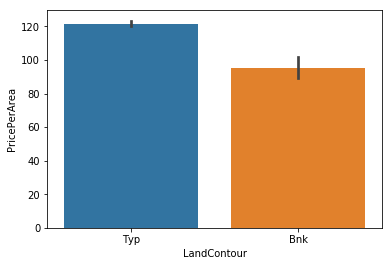

In [19]:
PlotCorr2(combinedData, 'LandContour')

There seem to be a reasonable correlation, so we keep this and convert it to 0, 1:

In [20]:
combinedData['LandContour'].replace(['Bnk', 'Typ'], [0, 1], inplace =  True)

**LandSlope**:

Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64


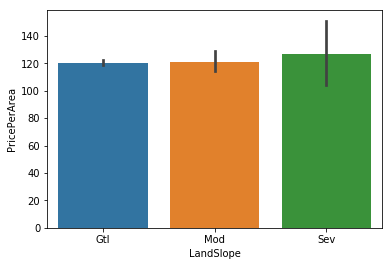

In [21]:
PlotCorr2(trData, 'LandSlope')

As there seem to be no correlation (even a stragne correlation that in Severe slope the price per area is higher!) we drop this feature. 

In [22]:
combinedData.drop('LandSlope', 1, inplace = True)

**Utilities**:

AllPub    2916
None         2
NoSeWa       1
Name: Utilities, dtype: int64


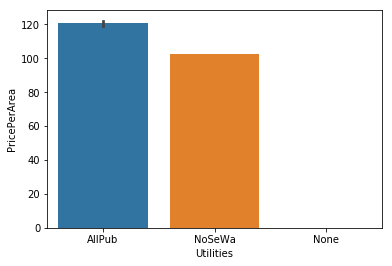

In [23]:
PlotCorr2(combinedData, 'Utilities')

In [24]:
combinedData['Utilities'].replace(['NoSeWa'], ['None'], inplace = True)

AllPub    2916
None         3
Name: Utilities, dtype: int64


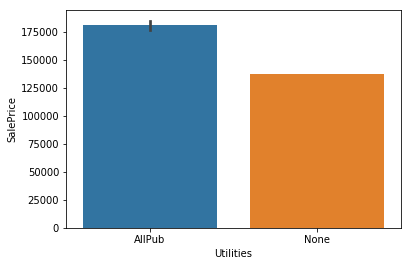

In [25]:
PlotCorr(combinedData, 'Utilities')

In [26]:
combinedData['Utilities'].replace(['AllPub', 'None'], [1, 0], inplace = True)

**MiscFeature**:

None    2814
Shed      95
Gar2       5
Othr       4
TenC       1
Name: MiscFeature, dtype: int64


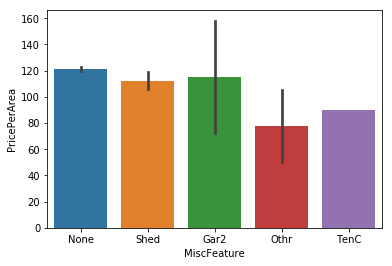

In [27]:
PlotCorr2(combinedData, 'MiscFeature')

There deoes not seem to be a meaningful correlation, so we drop this feature:

In [28]:
combinedData.drop('MiscFeature', 1, inplace = True)

5     825
6     731
7     600
8     342
4     226
9     107
3      40
10     31
2      13
1       4
Name: OverallQual, dtype: int64


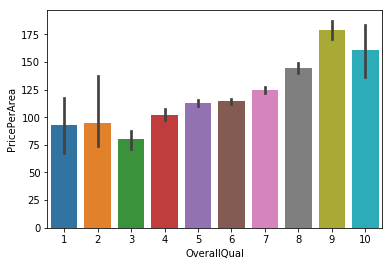

In [29]:
PlotCorr2(combinedData, 'OverallQual')

When we graph price per area vs overal quality, to our surprise, the Overal qual = 9 has a higher price per area than 10! So, we combine, 9 and 10. Also, 1, 2, and 3, will be replace by 1. 

In [30]:
combinedData['OverallQual'].replace([1, 2, 3, 9, 10], [1, 1, 1, 9, 9], inplace = True)

5    825
6    731
7    600
8    342
4    226
9    138
1     57
Name: OverallQual, dtype: int64


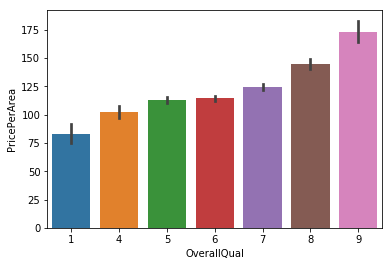

In [31]:
PlotCorr2(combinedData, 'OverallQual')

**ExterQual**:

TA    1798
Gd     979
Ex     107
Fa      35
Name: ExterQual, dtype: int64


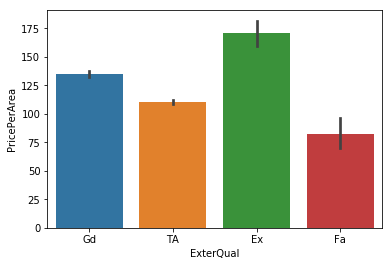

In [32]:
PlotCorr2(combinedData, 'ExterQual')

In [33]:
combinedData['ExterQual'].replace(['Fa', 'TA', 'Gd', 'Ex'], [0, 1, 2, 3], inplace = True)

1    1798
2     979
3     107
0      35
Name: ExterQual, dtype: int64


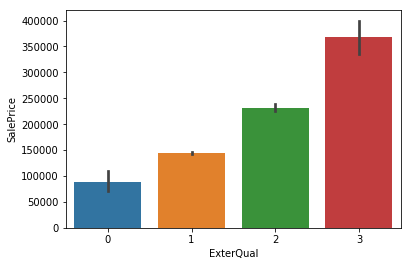

In [34]:
PlotCorr(combinedData, 'ExterQual')

**ExterCond**:

TA    2538
Gd     299
Fa      67
Ex      12
Po       3
Name: ExterCond, dtype: int64


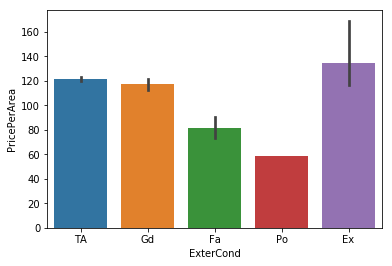

In [35]:
PlotCorr2(combinedData, 'ExterCond')

In [36]:
combinedData['ExterCond'].replace(['Po', 'Fa', 'TA', 'Gd', 'Ex'], [0, 1, 2, 2, 3], inplace = True)

2    2837
1      67
3      12
0       3
Name: ExterCond, dtype: int64


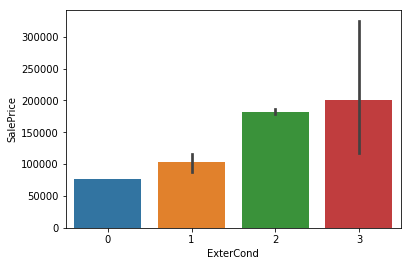

In [37]:
PlotCorr(combinedData, 'ExterCond')

**BsmtQual**:

TA      1283
Gd      1209
Ex       258
Fa        88
None      81
Name: BsmtQual, dtype: int64


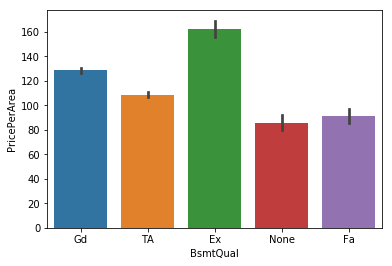

In [38]:
PlotCorr2(combinedData, 'BsmtQual')

In [39]:
combinedData['BsmtQual'].replace(['None', 'Fa', 'TA', 'Gd', 'Ex'], [0, 1, 2, 3, 4], inplace = True)

2    1283
3    1209
4     258
1      88
0      81
Name: BsmtQual, dtype: int64


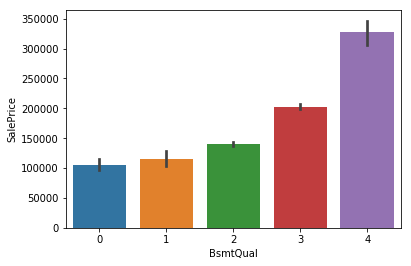

In [40]:
PlotCorr(combinedData, 'BsmtQual')

**BsmtCond**:

TA      2606
Gd       122
Fa       104
None      82
Po         5
Name: BsmtCond, dtype: int64


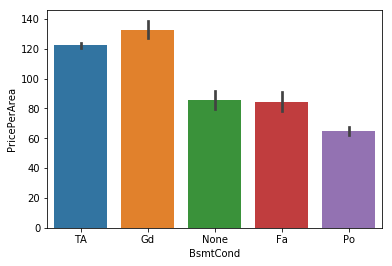

In [41]:
PlotCorr2(combinedData, 'BsmtCond')

In [42]:
combinedData['BsmtCond'].replace(['Po', 'None', 'Fa', 'TA', 'Gd'], [0, 1, 1, 2, 3], inplace = True)

2    2606
1     186
3     122
0       5
Name: BsmtCond, dtype: int64


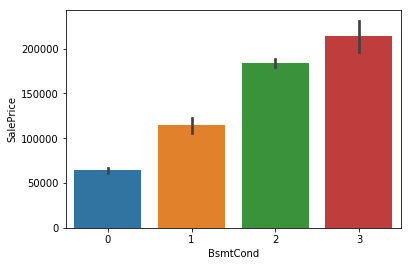

In [43]:
PlotCorr(combinedData, 'BsmtCond')

**BsmtExposure**:

No      1904
Av       418
Gd       276
Mn       239
None      82
Name: BsmtExposure, dtype: int64


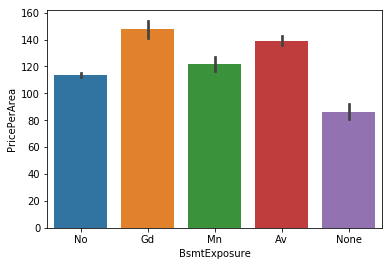

In [44]:
PlotCorr2(combinedData, 'BsmtExposure')

In [45]:
combinedData['BsmtExposure'].replace(['None', 'No', 'Mn', 'Av', 'Gd'], [0, 1, 2, 3, 4], inplace = True)

1    1904
3     418
4     276
2     239
0      82
Name: BsmtExposure, dtype: int64


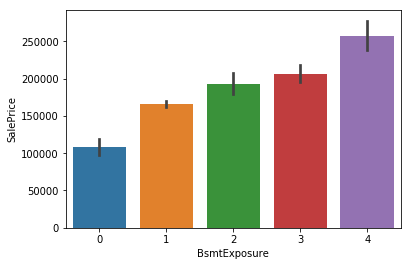

In [46]:
PlotCorr(combinedData, 'BsmtExposure')

Typ     2719
Min2      70
Min1      65
Mod       35
Maj1      19
Maj2       9
Sev        2
Name: Functional, dtype: int64


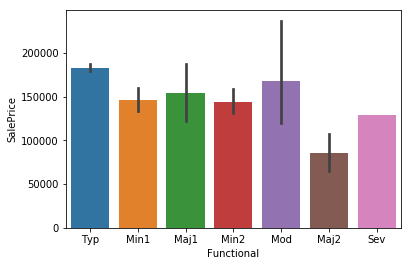

In [47]:
PlotCorr(combinedData, 'Functional')

In [48]:
combinedData['Functional'].replace(['Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'], 
                                   [0, 0, 1, 1, 1, 1, 2], inplace = True)

2    2719
1     189
0      11
Name: Functional, dtype: int64


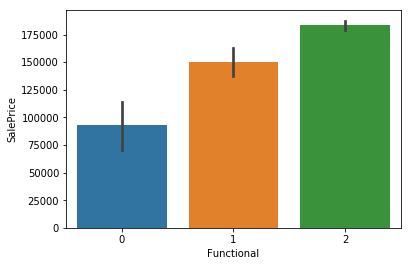

In [49]:
PlotCorr(combinedData, 'Functional')

**CentralAir**:

Y    2723
N     196
Name: CentralAir, dtype: int64


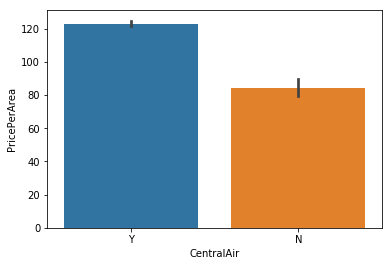

In [50]:
PlotCorr2(combinedData, 'CentralAir')

In [51]:
combinedData['CentralAir'].replace(['N', 'Y'], [0, 1], inplace = True)

1    2723
0     196
Name: CentralAir, dtype: int64


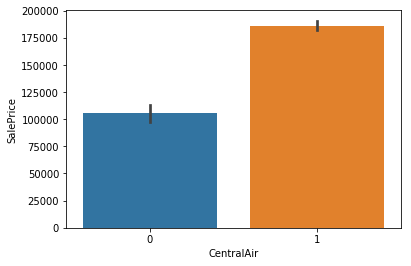

In [52]:
PlotCorr(combinedData, 'CentralAir')

**PavedDrive**:

Y    2641
N     216
P      62
Name: PavedDrive, dtype: int64


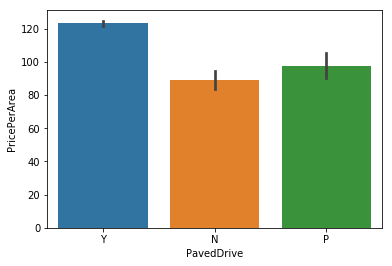

In [53]:
PlotCorr2(combinedData, 'PavedDrive')

In [54]:
combinedData['PavedDrive'].replace(['N', 'P', 'Y'], [0, 1, 2], inplace = True)

2    2641
0     216
1      62
Name: PavedDrive, dtype: int64


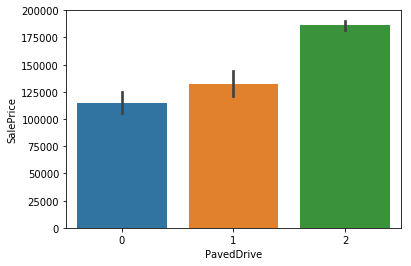

In [55]:
PlotCorr(combinedData, 'PavedDrive')

**PoolQC**:

None    2909
Gd         4
Ex         4
Fa         2
Name: PoolQC, dtype: int64


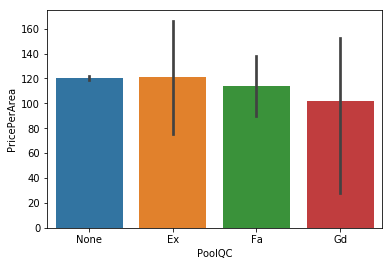

In [56]:
PlotCorr2(combinedData, 'PoolQC')

There is no meaningful correlation; moreover, there is a lot of variance in the data; so we drop this feature:

In [57]:
combinedData.drop('PoolQC', 1, inplace = True)

None     2348
MnPrv     329
GdPrv     118
GdWo      112
MnWw       12
Name: Fence, dtype: int64


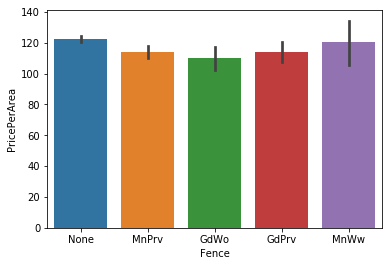

In [58]:
PlotCorr2(combinedData, 'Fence')

There does not seem to be a meaningful correlation, also, because given that no fence has a better average price than fence with Good privacy, and not much correlation with price per area we drop this feature:

In [59]:
combinedData.drop('Fence', 1, inplace = True)

**HeatingQC**:

Ex    1493
TA     857
Gd     474
Fa      92
Po       3
Name: HeatingQC, dtype: int64


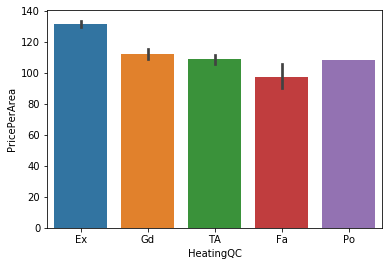

In [60]:
PlotCorr2(combinedData, 'HeatingQC')

In [61]:
combinedData['HeatingQC'].replace(['Po', 'Fa', 'TA', 'Gd', 'Ex'],[0, 0, 1, 2, 3], inplace = True)

3    1493
1     857
2     474
0      95
Name: HeatingQC, dtype: int64


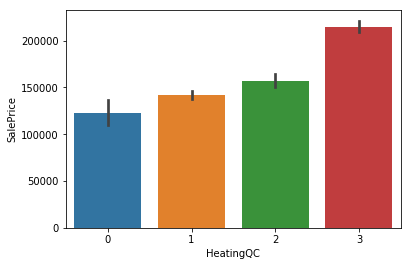

In [62]:
PlotCorr(combinedData, 'HeatingQC')

**FireplaceQu**:

None    1420
Gd       744
TA       592
Fa        74
Po        46
Ex        43
Name: FireplaceQu, dtype: int64


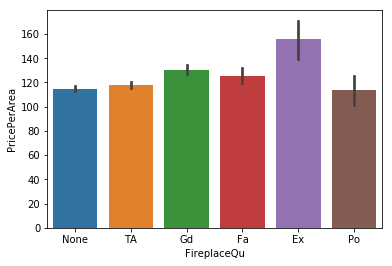

In [63]:
PlotCorr2(combinedData, 'FireplaceQu')

In [64]:
combinedData['FireplaceQu'].replace(['Po', 'None', 'TA', 'Fa', 'Gd', 'Ex'],[0, 0, 1, 2, 3, 4], inplace = True)

0    1466
3     744
1     592
2      74
4      43
Name: FireplaceQu, dtype: int64


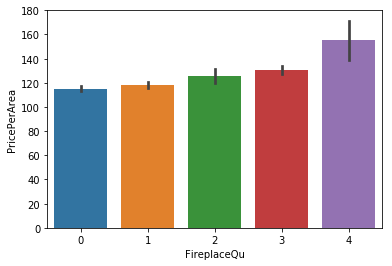

In [65]:
PlotCorr2(combinedData, 'FireplaceQu')

**KitchenQual**:

TA    1493
Gd    1151
Ex     205
Fa      70
Name: KitchenQual, dtype: int64


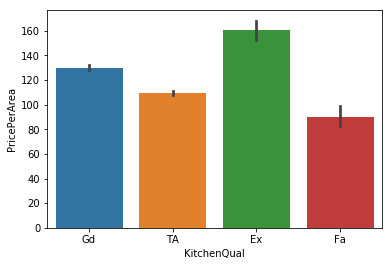

In [66]:
PlotCorr2(combinedData, 'KitchenQual')

In [67]:
combinedData['KitchenQual'].replace(['Fa', 'TA', 'Gd', 'Ex'],[0, 1, 2, 3], inplace = True)

1    1493
2    1151
3     205
0      70
Name: KitchenQual, dtype: int64


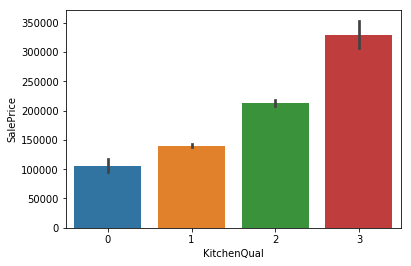

In [68]:
PlotCorr(combinedData, 'KitchenQual')

**GarageQual**:

TA      2604
None     159
Fa       124
Gd        24
Po         5
Ex         3
Name: GarageQual, dtype: int64


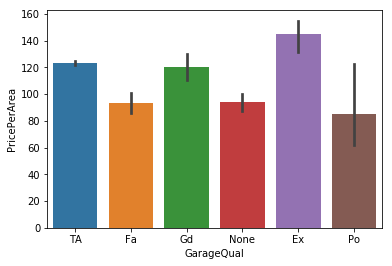

In [69]:
PlotCorr2(combinedData, 'GarageQual')

In [70]:
combinedData['GarageQual'].replace(['Po', 'None', 'Fa', 'TA', 'Gd', 'Ex'],[0, 1, 1, 2, 2, 3], inplace = True)

2    2628
1     283
0       5
3       3
Name: GarageQual, dtype: int64


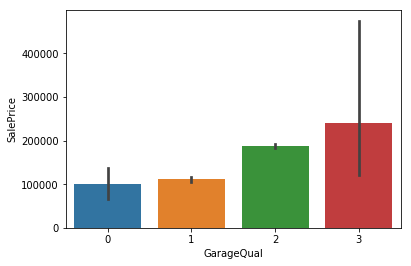

In [71]:
PlotCorr(combinedData, 'GarageQual')

**GarageCond**:

TA      2654
None     159
Fa        74
Gd        15
Po        14
Ex         3
Name: GarageCond, dtype: int64


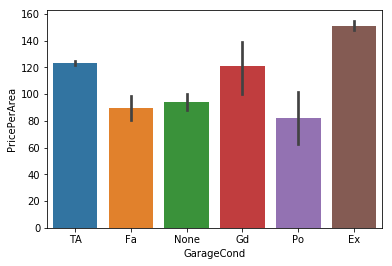

In [72]:
PlotCorr2(combinedData, 'GarageCond')

In [73]:
combinedData['GarageCond'].replace(['Po', 'None', 'Fa', 'TA', 'Gd', 'Ex'],[0, 1, 1, 2, 2, 3], inplace = True)

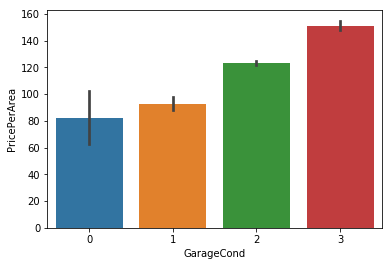

In [74]:
sns.barplot(x = combinedData['GarageCond'], y = combinedData['PricePerArea']) # NOTE PER AREA!!

**BsmtFinType1**:

Unf     851
GLQ     849
ALQ     429
Rec     288
BLQ     269
LwQ     154
None     79
Name: BsmtFinType1, dtype: int64


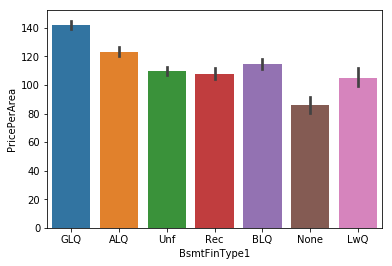

In [75]:
PlotCorr2(combinedData, 'BsmtFinType1')

In [76]:
combinedData['BsmtFinType1'].replace(['None', 'LwQ', 'Rec', 'Unf', 'BLQ', 'ALQ', 'GLQ'],[0, 1, 2, 2, 3, 4, 5], inplace = True)

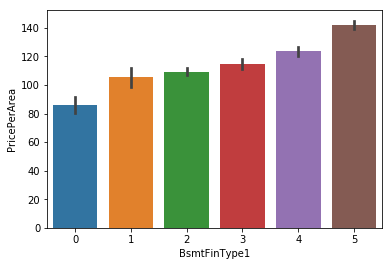

In [77]:
sns.barplot(x = combinedData['BsmtFinType1'], y = combinedData['PricePerArea'])

**BsmtFinType2**:

Unf     2493
Rec      105
LwQ       87
None      80
BLQ       68
ALQ       52
GLQ       34
Name: BsmtFinType2, dtype: int64


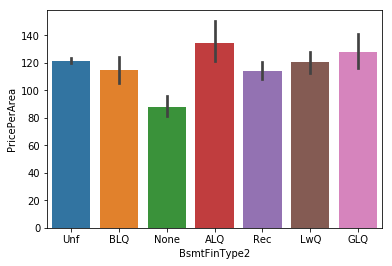

In [78]:
PlotCorr2(combinedData, 'BsmtFinType2')

In [79]:
combinedData['BsmtFinType2'].replace(['None', 'Rec', 'BLQ', 'Unf', 'LwQ', 'ALQ', 'GLQ'],[0, 1, 1, 2, 2, 4, 4], inplace = True)

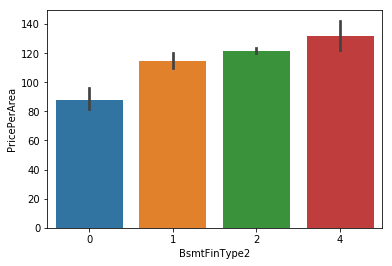

In [80]:
sns.barplot(x = combinedData['BsmtFinType2'], y = combinedData['PricePerArea'])

**GarageFinish**:

Unf     1230
RFn      811
Fin      719
None     159
Name: GarageFinish, dtype: int64


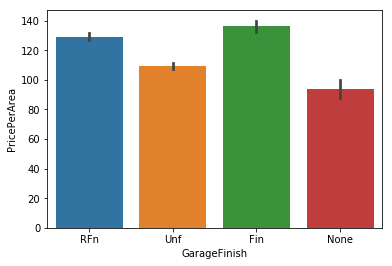

In [81]:
PlotCorr2(combinedData, 'GarageFinish')

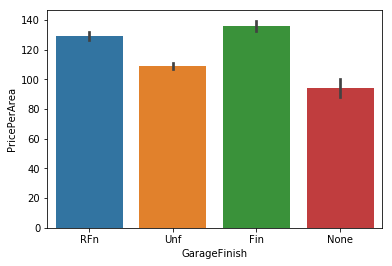

In [82]:
sns.barplot(x = combinedData['GarageFinish'], y = combinedData['PricePerArea'])

In [83]:
combinedData['GarageFinish'].replace(['None', 'Unf', 'RFn', 'Fin'],[0, 1, 2, 3], inplace = True)

1    1230
2     811
3     719
0     159
Name: GarageFinish, dtype: int64


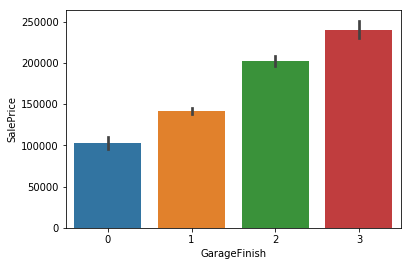

In [84]:
PlotCorr(combinedData, 'GarageFinish')

**YrSold**:

2007    692
2009    647
2008    622
2006    619
2010    339
Name: YrSold, dtype: int64


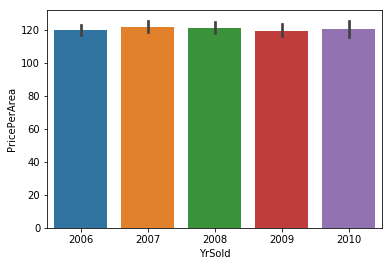

In [85]:
PlotCorr2(combinedData, 'YrSold')

There seem to be no correlation. so, we will later drop yrSold:

**MoSold**:

6     503
7     446
5     394
4     279
8     233
3     232
10    173
9     158
11    142
2     133
1     122
12    104
Name: MoSold, dtype: int64


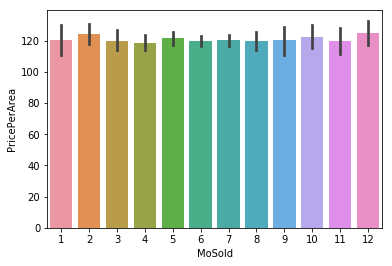

In [86]:
PlotCorr2(combinedData, 'MoSold')

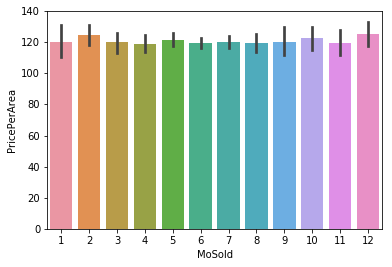

In [87]:
sns.barplot(x = combinedData['MoSold'], y = combinedData['PricePerArea'])

Similarly, for month of sale, there seem to be little correlation. So, we drop this feature as well:

In [88]:
combinedData.drop('MoSold', 1, inplace = True)

In [89]:
ltr = len(trData)
ltest = len(testData)
trData = combinedData[0:ltr].reset_index(drop = True)
testData = combinedData[ltr:ltr+ltest].reset_index(drop = True)

**Other non-numeric featuers**:

In [90]:
trData.dtypes[trData.dtypes == 'object']

Alley            object
BldgType         object
Condition1       object
Condition2       object
Electrical       object
Exterior1st      object
Exterior2nd      object
Foundation       object
GarageType       object
Heating          object
HouseStyle       object
LotConfig        object
LotShape         object
MSZoning         object
MasVnrType       object
Neighborhood     object
RoofMatl         object
RoofStyle        object
SaleCondition    object
SaleType         object
Street           object
dtype: object

In [91]:
combinedData = pd.concat(objs = [trData, testData], axis=0).reset_index(drop = True)

### Graph the price (output) and features (input) distributions:

Text(0,0.5,'Counts')

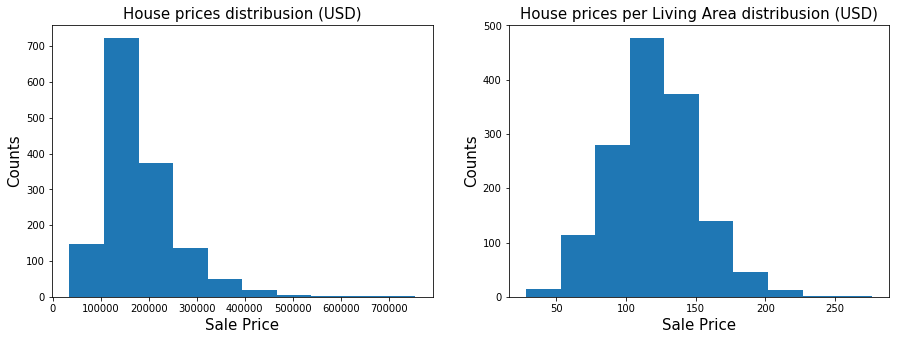

In [92]:
f, ax = plt.subplots(1, 2, figsize = (15, 5))
FZ = 15
ax[0].hist(trData['SalePrice'])
ax[0].set_title('House prices distribusion (USD)', fontsize = FZ)
ax[0].set_xlabel('Sale Price', fontsize = FZ)
ax[0].set_ylabel('Counts', fontsize = FZ)

ax[1].hist(trData['SalePrice'] / trData['GrLivArea'])
ax[1].set_title('House prices per Living Area distribusion (USD)', fontsize = FZ)
ax[1].set_xlabel('Sale Price', fontsize = FZ)
ax[1].set_ylabel('Counts', fontsize = FZ)

For simplicity we will convert the price to $1000:

In [93]:
trData['SalePriceK'] = trData['SalePrice'] / 1000

The average house price per square feet of living area (GrLivArea) is around 120 USD. 

### 2.3 Remove the outliers

Text(0.5,0,'GrLivArea')

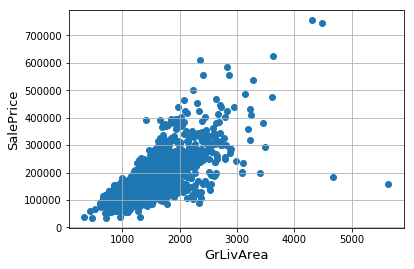

In [94]:
plt.scatter(x = trData['GrLivArea'], y = trData['SalePrice'])
plt.grid()
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)

In [95]:
trData.drop(trData[(trData['GrLivArea']>4000) & (trData['SalePrice']<300000)].index, inplace = True)
combinedData = pd.concat(objs = [trData, testData], axis = 0).reset_index(drop = True)

After removing the two outliers:

Text(0.5,0,'GrLivArea')

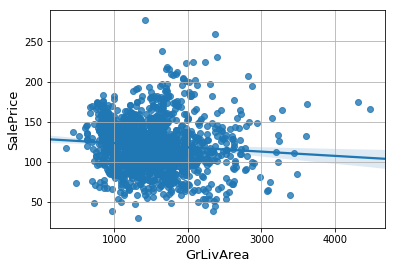

In [96]:
sns.regplot(x = trData['GrLivArea'], y = trData['SalePrice'] /trData['GrLivArea'])
plt.grid()
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)

In [97]:
# sns.barplot(x = trData['Neighborhood'], y = trData['SalePrice'] / trData['GrLivArea'])

In [98]:
# ngbhrData = trData[['Neighborhood', 'PricePerArea']].groupby('Neighborhood', as_index = False).mean()

In [99]:
# ngbhrData['PricePerArea']

In [100]:
# trData['Neighborhood'].value_counts()

Text(0.5,0,'GrLivArea')

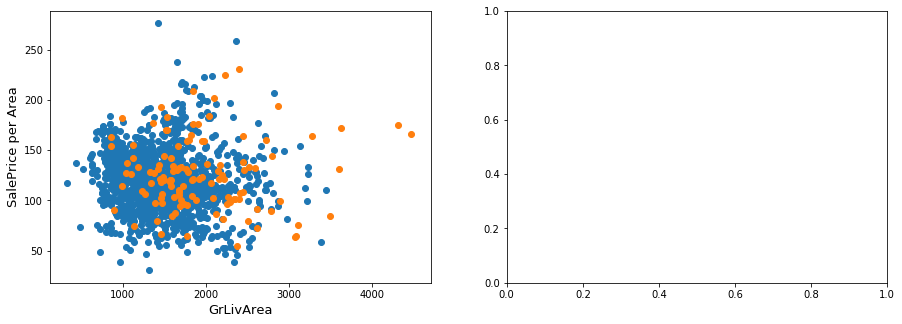

In [101]:
trDataNrmArea = trData[trData['LotArea'] <= 15000]
trDataLrgArea = trData[trData['LotArea'] > 15000]
f, ax = plt.subplots(1, 2, figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.scatter(x = trDataNrmArea['GrLivArea'], y = trDataNrmArea['SalePrice'] / trDataNrmArea['GrLivArea'])
plt.grid()
plt.ylabel('SalePrice per Area', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)

plt.scatter(x = trDataLrgArea['GrLivArea'], y = trDataLrgArea['SalePrice'] / trDataLrgArea['GrLivArea'])
plt.grid()
plt.ylabel('SalePrice per Area', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)

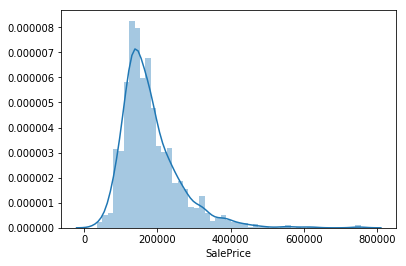

In [102]:
sns.distplot(trData['SalePrice'])

Another possiblity for outliers is the price per area. There is only one house with a price per square foot less than $31, and the next lowest price is $40, so, we remove the cheapest one:

In [103]:
trData[trData['SalePrice'] / trData['GrLivArea'] < 31]

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,SalePriceK
30,649,668,0,Pave,3,1Fam,2,1,0.000,0.000,...,0,Pave,6,649.000,1,0,1920,1950,2008,40.000


In [104]:
trData.drop(trData[trData['SalePrice'] / trData['GrLivArea'] < 31].index, inplace = True)

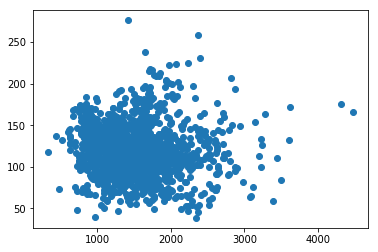

In [105]:
plt.scatter(x = trData['GrLivArea'], y = trData['SalePrice'] / trData['GrLivArea'])

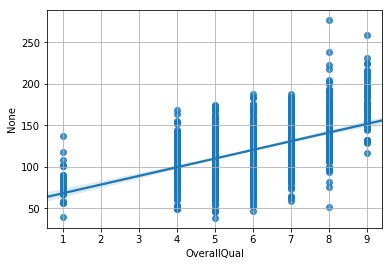

In [106]:
sns.regplot(x = trData['OverallQual'], y = trData['SalePrice'] / trData['GrLivArea'])
plt.grid()

## 3. Feature engineering
We investigate the correlation between the features and the sale price.

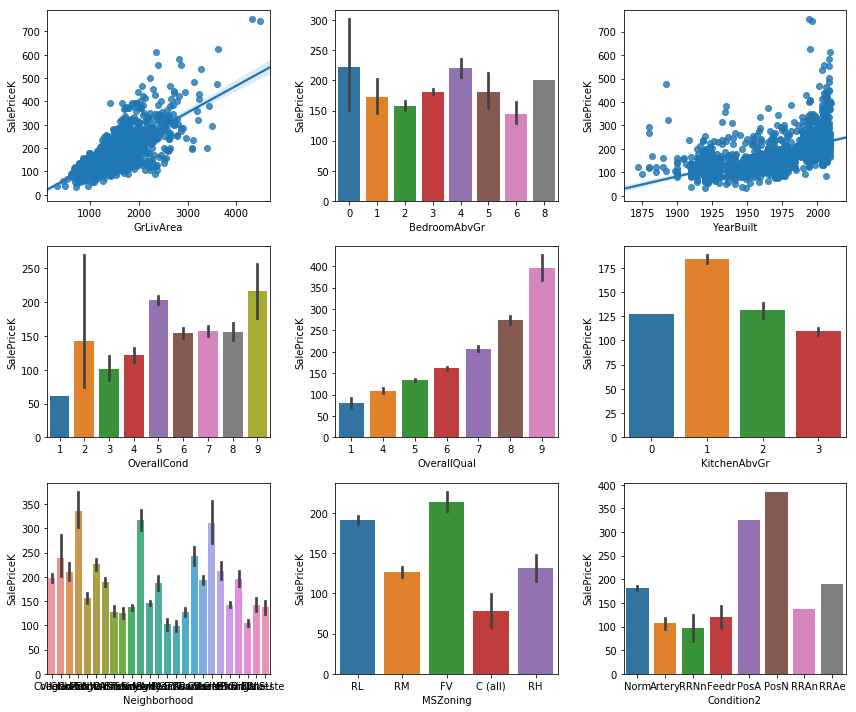

In [107]:
f, ax = plt.subplots(3, 3, figsize = (12, 10))
plt.subplot(3, 3, 1)
sns.regplot(x = 'GrLivArea', y = 'SalePriceK', data = trData)
plt.subplot(3, 3, 2)
sns.barplot(x = 'BedroomAbvGr', y = 'SalePriceK', data = trData)
plt.subplot(3, 3, 3)
sns.regplot(x = 'YearBuilt', y = 'SalePriceK', data = trData)
plt.subplot(3, 3, 4)
sns.barplot(x = 'OverallCond', y = 'SalePriceK', data = trData)
plt.subplot(3, 3, 5)
sns.barplot(x = 'OverallQual', y = 'SalePriceK', data = trData)
plt.subplot(3, 3, 6)
sns.barplot(x = 'KitchenAbvGr', y = 'SalePriceK', data = trData)
plt.subplot(3, 3, 7)
sns.barplot(x = 'Neighborhood', y = 'SalePriceK', data = trData)
plt.subplot(3, 3, 8)
sns.barplot(x = 'MSZoning', y = 'SalePriceK', data = trData)
plt.subplot(3, 3, 9)
sns.barplot(x = 'Condition2', y = 'SalePriceK', data = trData)
plt.tight_layout() 

In [108]:
# for data in data_list:
#     data['GarageCarsSmple'] = data['GarageCars'].replace(4, 3)

In [109]:
# sns.barplot(x = 'HalfFullBath', y = 'SalePriceK', data = trData)
# print(trData['HalfFullBath'].value_counts())

In [110]:
# sns.barplot(x = 'HasDeckPorch', y = 'SalePriceK', data = trData)
# print(trData['HasDeckPorch'].value_counts())

In [111]:
# sns.regplot(x = 'LowQualFinSF', y = 'SalePriceK', data = trData)
# print(trData['LowQualFinSF'].value_counts())
# CheckNull(combinedData, 'LowQualFinSF')

Since only 'Gd' condition has a significant different with the rest, we define a new feature: 

In [112]:
# for data in data_list:
#     data['BsmtExposureGd'] = (data['BsmtExposure'] == 'Gd') * 1

In [113]:
data_list = [trData, testData]
for data in data_list:
    data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']
#     data['TotalBath'] = data['BsmtFullBath'] + data['BsmtHalfBath'] + data['FullBath'] + data['HalfBath']
#     data['TotalPorch'] = data['WoodDeckSF'] + data['OpenPorchSF'] + data['EnclosedPorch'] + data['3SsnPorch'] + data['ScreenPorch'] 
#     data['TotalBsmtFinSF'] = data['BsmtFinSF1'] + data['BsmtFinSF2']

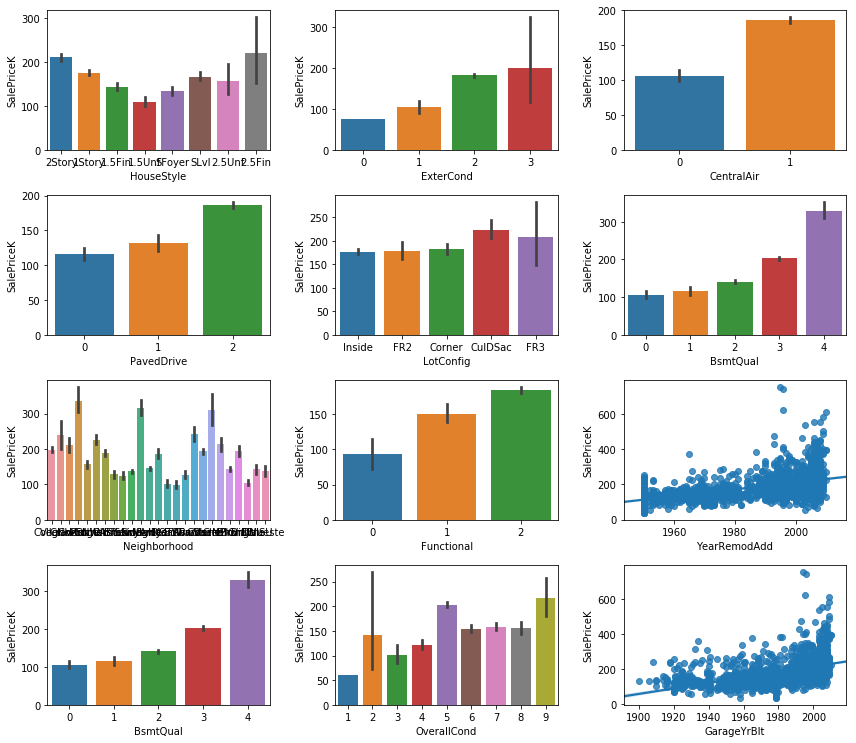

In [114]:
f, ax = plt.subplots(3, 3, figsize = (12, 10))
plt.subplot(4, 3, 1)
sns.barplot(x = 'HouseStyle', y = 'SalePriceK', data = trData)
plt.subplot(4, 3, 2)
sns.barplot(x = 'ExterCond', y = 'SalePriceK', data = trData)
plt.subplot(4, 3, 3)
sns.barplot(x = 'CentralAir', y = 'SalePriceK', data = trData)
plt.subplot(4, 3, 4)
sns.barplot(x = 'PavedDrive', y = 'SalePriceK', data = trData)
plt.subplot(4, 3, 5)
sns.barplot(x = 'LotConfig', y = 'SalePriceK', data = trData)
plt.subplot(4, 3, 6)
sns.barplot(x = 'BsmtQual', y = 'SalePriceK', data = trData)
plt.subplot(4, 3, 7)
sns.barplot(x = 'Neighborhood', y = 'SalePriceK', data = trData)
plt.subplot(4, 3, 8)
sns.barplot(x = 'Functional', y = 'SalePriceK', data = trData)
plt.subplot(4, 3, 9)
sns.regplot(x = 'YearRemodAdd', y = 'SalePriceK', data = trData)
plt.tight_layout() 
plt.subplot(4, 3, 10) 
sns.barplot(x = 'BsmtQual', y = 'SalePriceK', data = trData)
plt.subplot(4, 3, 11) 
sns.barplot(x = 'OverallCond', y = 'SalePriceK', data = trData) 
plt.subplot(4, 3, 12) 
sns.regplot(x = 'GarageYrBlt', y = 'SalePriceK', data = trData)

House age seems to be an important feature correlated with the saleprice:

In [115]:
ngbhrData = trData[['Neighborhood', 'PricePerArea']].groupby('Neighborhood').mean()
MSSubClassVsPricePerArea = combinedData[['MSSubClass', 'PricePerArea']].groupby('MSSubClass').mean()
MSZoningVsPricePerArea = trData[['MSZoning', 'PricePerArea']].groupby('MSZoning').mean()
HouseStylePricePerArea = combinedData[['HouseStyle', 'PricePerArea']].groupby('HouseStyle').mean()
SaleTypePricePerArea = combinedData[['SaleType', 'PricePerArea']].groupby('SaleType').mean()
SaleConditionPricePerArea = combinedData[['SaleCondition', 'PricePerArea']].groupby('SaleCondition').mean()

In [116]:
MSSubClassVsPricePerArea.fillna(MSSubClassVsPricePerArea['PricePerArea'].mean(), inplace = True)

In [117]:
len(combinedData['MSSubClass'].value_counts())

16

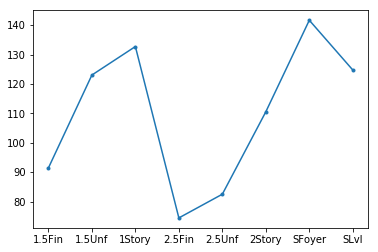

In [118]:
plt.plot(HouseStylePricePerArea, '.-')

In [119]:
# trData['Neighborhood'].value_counts()

In [120]:
# for data in data_list:
#     data['NeighborhoodPrice'] = data['Neighborhood'].apply(lambda x: ngbhrData['PricePerArea'][x])
#     data['MSSubClassPrice'] = data['MSSubClass'].apply(lambda x: MSSubClassVsPricePerArea['PricePerArea'][x])
#     data['MSZoningPrice'] = data['MSZoning'].apply(lambda x: MSZoningVsPricePerArea['PricePerArea'][x])
#     data['HouseStylePrice'] = data['HouseStyle'].apply(lambda x: HouseStylePricePerArea['PricePerArea'][x])
#     data['SaleTypePrice'] = data['SaleType'].apply(lambda x: SaleTypePricePerArea['PricePerArea'][x]) 
#     data['SaleConditionPrice'] = data['SaleCondition'].apply(lambda x: SaleConditionPricePerArea['PricePerArea'][x])        

In [121]:
trData['YearBuilt'].describe()

count   1457.000
mean    1971.253
std       30.174
min     1872.000
25%     1954.000
50%     1973.000
75%     2000.000
max     2010.000
Name: YearBuilt, dtype: float64

In [122]:
data_list = [trData, testData]
for data in data_list:
    data['HouseAge'] = data['YrSold'] - data['YearBuilt']
    data['YrfromRemod'] = data['YrSold'] - data['YearRemodAdd']
#     data['YrSoldFrom2006'] = data['YrSold'] - 2006
#     data['YrBuiltFrom1971'] = data['YearBuilt'] - 1971
trData.drop('YrSold', 1, inplace = True)
testData.drop('YrSold', 1, inplace = True)
trData.drop('YearBuilt', 1, inplace = True)
testData.drop('YearBuilt', 1, inplace = True)

In [123]:
cor_col = ['GrLivArea', 'HouseAge', 'OverallCond', 'OverallQual', 'KitchenAbvGr', 'GarageArea', 
           'Functional', 'TotalBsmtSF',  'MSSubClass', 'NeighborhoodCode', 'MSZoningCode',
           'BldgTypeCode', 'HouseStyleCode', 'FoundationCode', 'CentralAirCode', 'PavedDriveCode', 
           'LotArea', 'RoofStyleCode', 'SalePrice']
cor_col = ['GrLivArea', 'OverallQual', 'BsmtFinSF1', 'HouseAge', 'Neighborhood', 'YearRemodAdd', 
           'LotArea', 'OverallCond', 'Fireplaces',
           'HouseStyle', 'MSSubClass',  'BsmtQual', 'PavedDrive', 'TotalSF', 
           'MSZoning', 'BsmtExposure', 'Functional', 'Street', 
           'SalePriceK'
                    ]

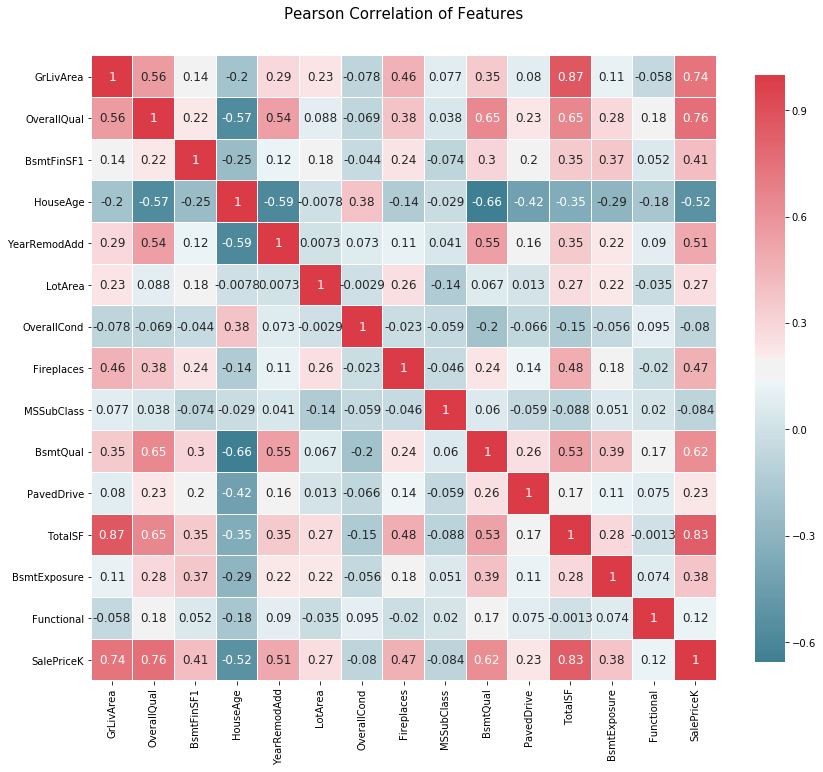

In [124]:
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(trData[cor_col])

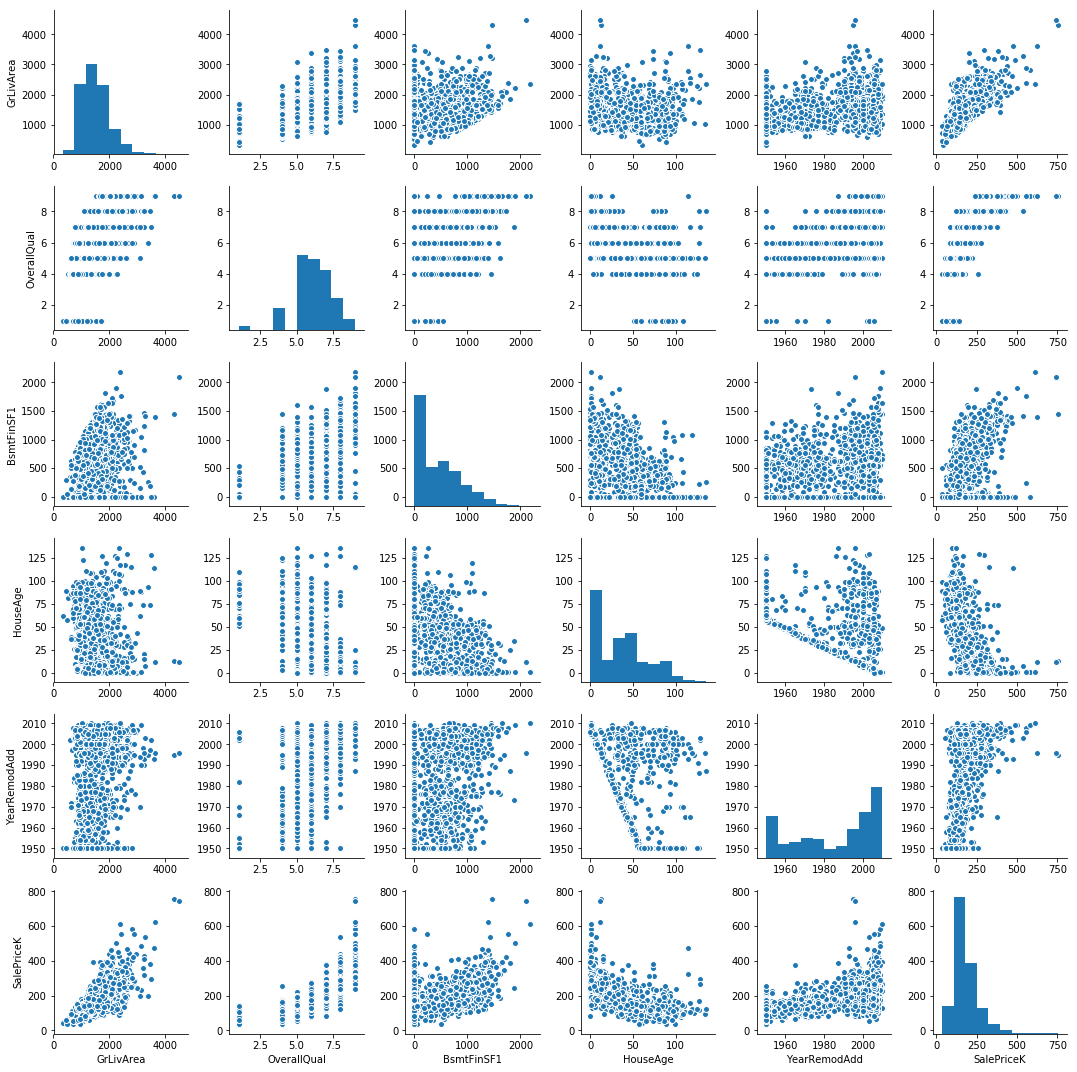

In [125]:
cor_col_smpl = ['GrLivArea', 'OverallQual', 'BsmtFinSF1', 'HouseAge', 'Neighborhood', 'YearRemodAdd', 
           'SalePriceK']
sns.pairplot(trData[cor_col_smpl])
plt.show()

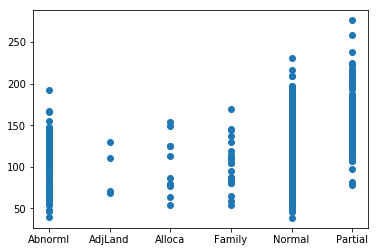

In [126]:
plt.scatter(x = trData['SaleCondition'], y = trData['PricePerArea'])

**GarageYrBlt**:

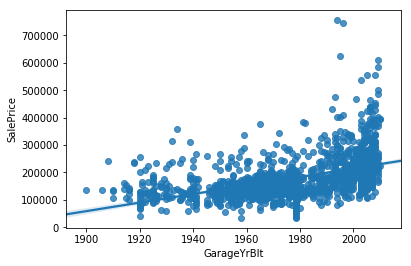

In [127]:
sns.regplot(x = combinedData['GarageYrBlt'], y = combinedData['SalePrice'])

In [128]:
combinedData[combinedData['GarageYrBlt'] > 2010]['GarageYrBlt']

2590   2207.000
Name: GarageYrBlt, dtype: float64

In [129]:
testData.loc[testData['GarageYrBlt'] > 2010, 'GarageYrBlt'] = 2010

**GarageCars and GarageArea**:

2.000    1594
1.000     776
3.000     373
0.000     157
4.000      16
5.000       1
Name: GarageCars, dtype: int64


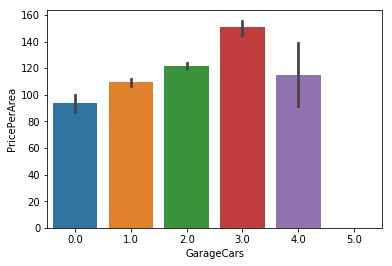

In [130]:
PlotCorr2(combinedData, 'GarageCars')

In [131]:
combinedData['GarageCars'].replace([4, 5], 3, inplace = True)

2.000    1594
1.000     776
3.000     390
0.000     157
Name: GarageCars, dtype: int64


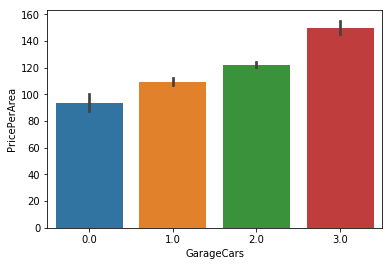

In [132]:
PlotCorr2(combinedData, 'GarageCars')

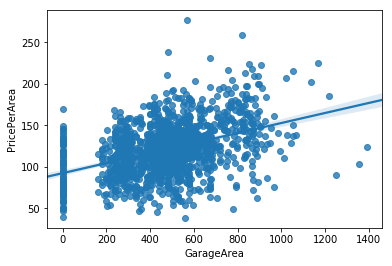

In [133]:
sns.regplot(x = trData['GarageArea'], y = trData['PricePerArea'])

**Pool Area**:

0      2905
561       1
555       1
519       1
800       1
738       1
648       1
576       1
512       1
444       1
368       1
228       1
144       1
Name: PoolArea, dtype: int64

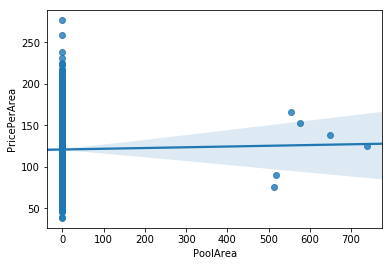

In [134]:
sns.regplot(x = trData['PoolArea'], y = trData['PricePerArea'])
combinedData['PoolArea'].value_counts()

We drop the PoolArea as there seem to be no reliable information in it:

In [135]:
combinedData.drop('PoolArea', 1, inplace = True)

**BsmtFullBath**:

0.000    1707
1.000    1171
2.000      37
3.000       2
Name: BsmtFullBath, dtype: int64


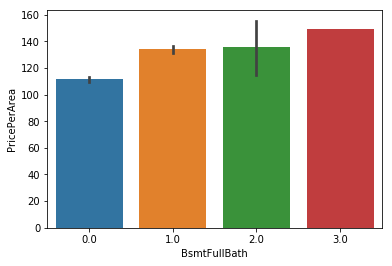

In [136]:
PlotCorr2(combinedData, 'BsmtFullBath')

**BsmtHalfBath**:

0.000    2742
1.000     171
2.000       4
Name: BsmtHalfBath, dtype: int64


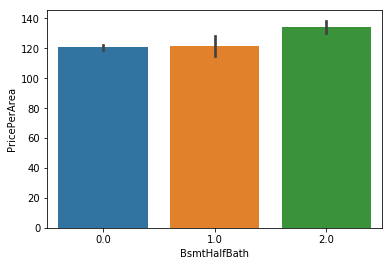

In [137]:
PlotCorr2(combinedData, 'BsmtHalfBath')

**MiscVal**:

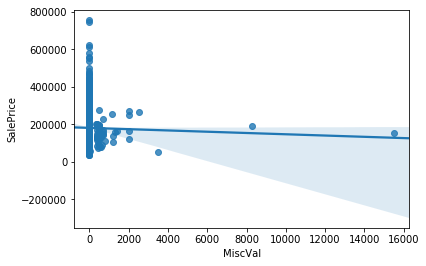

In [138]:
sns.regplot(x = combinedData['MiscVal'], y = combinedData['SalePrice'])

We drop the feature for obvious reasons:

In [139]:
combinedData.drop('MiscVal', 1, inplace = True)

**Porch**:

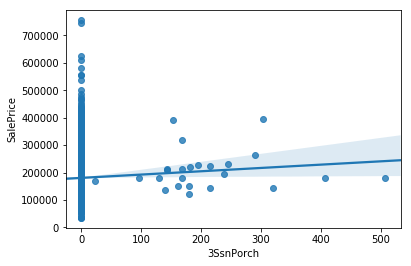

In [140]:
sns.regplot(x = combinedData['3SsnPorch'], y = combinedData['SalePrice'])

**Kitchen**:

1    2783
2     129
0       3
3       2
Name: KitchenAbvGr, dtype: int64


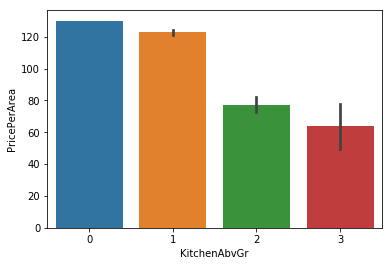

In [141]:
PlotCorr2(combinedData, 'KitchenAbvGr')

In [142]:
combinedData = pd.concat(objs=[trData, testData], axis = 0).reset_index(drop = True)

GasA     2871
GasW       27
Grav        9
Wall        6
OthW        2
Floor       1
Name: Heating, dtype: int64


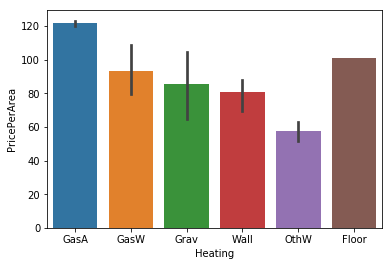

In [143]:
PlotCorr2(combinedData, 'Heating')

In [144]:
combinedData['Heating'].replace(['Floor', 'OthW', 'Wall', 'Grav'], 'Rare', inplace = True)

GasA    2871
GasW      27
Rare      18
Name: Heating, dtype: int64


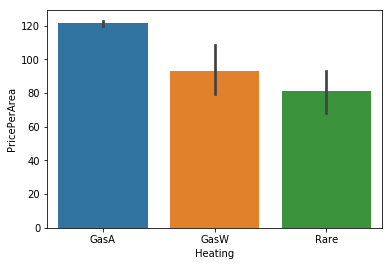

In [145]:
PlotCorr2(combinedData, 'Heating')

SBrkr    2669
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64


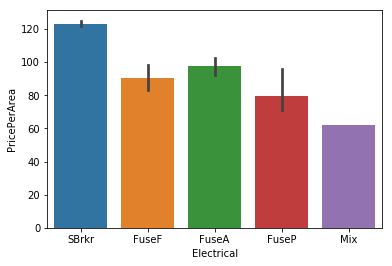

In [146]:
PlotCorr2(combinedData, 'Electrical')

In [147]:
combinedData['Electrical'].replace(['Mix', 'FuseP'], 'Rare', inplace = True)

SBrkr    2669
FuseA     188
FuseF      50
Rare        9
Name: Electrical, dtype: int64


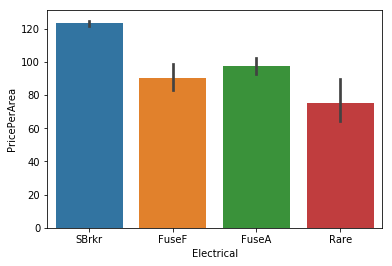

In [148]:
PlotCorr2(combinedData, 'Electrical')

Normal     2401
Partial     243
Abnorml     190
Family       46
Alloca       24
AdjLand      12
Name: SaleCondition, dtype: int64


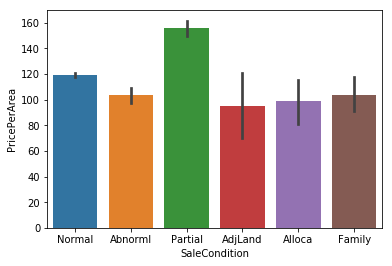

In [149]:
PlotCorr2(combinedData, 'SaleCondition')

<a id = 'sec_convert_to_dummies'></a>
#### 3.2.1 Convert categorial to dummies
The following variables are categorial type features:

MSSubClass, MSZoning, Alley, LotShape, LotConfig, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, Foundation, Heating, Electrical, GarageType, SaleType, SaleCondition

In [150]:
ltr = len(trData)
ltest = len(testData)
combinedData = pd.concat(objs=[trData, testData], axis = 0).reset_index(drop = True)
combinedData = pd.get_dummies(combinedData, columns=['MSSubClass', 'MSZoning', 'Alley', 'Street', 'LotShape', 'LotConfig', 
                                                     'Neighborhood', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 
                                                     'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType', 
                                                     'SaleType', 'SaleCondition'])
# trData = pd.get_dummies(trData, columns=['MSSubClass', 'MSZoning', 'Alley', 'Street', 'LotShape', 'LotConfig', 'Neighborhood', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'SaleType', 'SaleCondition'])
# testData = pd.get_dummies(testData, columns=['MSSubClass', 'MSZoning', 'Alley', 'Street', 'LotShape', 'LotConfig', 'Neighborhood', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'SaleType', 'SaleCondition'])
trData = combinedData[0:ltr].reset_index(drop = True)
testData = (combinedData[ltr:ltr+ltest].reset_index(drop = True)).drop('SalePrice', 1)

In [151]:
print(testData.shape)
print(trData.shape)

(1459, 192)
(1457, 193)


In [152]:
combinedData = pd.concat(objs = [trData, testData], axis=0).reset_index(drop = True)
conditionList = combinedData['Condition1'].unique()
Condition1Dummies = pd.get_dummies(combinedData['Condition1'], columns = ['Condition1'])
Condition2Dummies = pd.get_dummies(combinedData['Condition2'], columns = ['Condition2'])
ConditionDummies = Condition1Dummies
for colName in Condition2Dummies.columns:
    ConditionDummies[colName] += Condition2Dummies[colName]
    ConditionDummies[colName]  = (ConditionDummies[colName] > 0) * 1 # To prevent duplicates
ConditionDummies.drop('Norm', 1, inplace = True);
for colName in ConditionDummies.columns:
    trData[colName] = ConditionDummies[colName][0:ltr].reset_index(drop = True)
    testData[colName] = ConditionDummies[colName][ltr:ltr+ltest].reset_index(drop = True)

exteriorList = combinedData['Exterior1st'].unique()
exterior1Dummies = pd.get_dummies(combinedData['Exterior1st'], columns = ['Exterior1st'])
exterior2Dummies = pd.get_dummies(combinedData['Exterior2nd'], columns = ['Exterior2nd'])
exterior2Dummies.rename(columns={'Brk Cmn':'BrkComm', 'CmentBd':'CemntBd', 'Wd Shng':'WdShing'}, inplace = True);

exteriorDummies = exterior2Dummies
for colName in exterior1Dummies.columns:
    exteriorDummies[colName] += exterior1Dummies[colName]
    exteriorDummies[colName]  = (exteriorDummies[colName] > 0) * 1 # To prevent duplicates
for colName in exteriorDummies.columns:
    trData[colName] = exteriorDummies[colName][0:ltr].reset_index(drop = True)
    testData[colName] = exteriorDummies[colName][ltr:ltr+ltest].reset_index(drop = True)   

In [153]:
data_list = [trData, testData]
for data in data_list:
    data.drop('Condition1', 1, inplace = True)
    data.drop('Condition2', 1, inplace = True)
    data.drop('Exterior1st', 1, inplace = True)
    data.drop('Exterior2nd', 1, inplace = True)

#### Regularization: (thanks to @papiu on kaggle.com)

In [154]:
combinedData = pd.concat(objs=[trData, testData], axis = 0).reset_index(drop = True)

#log transform skewed numeric features:
numeric_feats = combinedData.dtypes[combinedData.dtypes != "object"].index
skewed_feats = combinedData[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 1]
skewed_feats = skewed_feats.index
combinedData[skewed_feats] = np.log1p(combinedData[skewed_feats])
ltr = len(trData)
ltest = len(testData)
trData = combinedData[0:ltr].reset_index(drop = True)
testData = combinedData[ltr:ltr+ltest].reset_index(drop = True).drop(['SalePrice', 'SalePriceK', 'PricePerArea'], 1)

## 4. Train the models and predict

In [155]:
selected_features = ['GrLivArea', 'HouseAge', 'OverallQual', 'BedroomAbvGr', 'KitchenAbvGr', 
                     'FullBath', 'GarageArea', 'Fireplaces', 'MSSubClass', 
                     'MSZoningCode', 'BldgTypeCode', 'HouseStyleCode', 
                     'FoundationCode', 'CentralAirCode', 'PavedDriveCode', 'LotArea', 
                     'YearRemodAdd', 'BsmtQualCode', 'TotRmsAbvGrd', 'OverallCond',
                     'MasVnrTypeCode', 'BsmtExposureGd', 'YearBuilt', 'GarageTypeSmpleCode', 'GarageCarsSmple',
                     'HasDeckPorch', 'BsmtFinSF1', 'NeighborhoodCode', 'TotalSF', 'FunctionalCode', 'ElectricalCode']
# good GarageCarsSmple HouseStyleCode CentralAirCode BsmtQualCode OverallCond Fireplaces TotalBsmtSF MSSubClass MSZoningCode
# bad BsmtExposureGd GarageArea FoundationCode LandContour HasDeckPorch FullBath MasVnrTypeCode BedroomAbvGr
# bad PavedDriveCode BldgTypeBsmtExposureGdCode GarageTypeSmpleCode KitchenAbvGr
selected_features = ['GrLivArea', 'OverallQual', 'BsmtFinSF1', 'HouseAge', 'YearRemodAdd', 
                    'GarageCars', 'LotArea', 'OverallCond', 'Fireplaces',
                    'MSSubClassPrice',  'BsmtQualCode', 'PavedDriveCode', 'TotalSF', 
                    'BsmtExposureGd', 'ElectricalCode', 'FunctionalCode', 'NeighborhoodPrice', 'MSZoningPrice',
                    'SaleTypePrice', 'SaleConditionPrice', 
                    'ExterCondCode',
                     'Artery', 'Feedr', 'PosA', 'PosN', 'RRAe', 'RRAn', 'RRNe', 'RRNn',
                    'AsbShng', 'AsphShn', 'BrkComm', 'BrkFace', 'CBlock', 'CemntBd',
                    'HdBoard', 'ImStucc', 'MetalSd', 'Other', 'Plywood', 'Stone', 'Stucco',
                    'VinylSd', 'Wd Sdng', 'WdShing',
                    '1.5Fin', '1.5Unf', '1Story', '2.5Fin', '2.5Unf', '2Story', 'SFoyer',
                    'SLvl'
                    ]

X = trData.drop(['SalePrice', 'SalePriceK', 'PricePerArea', 'Id'], 1)
y = trData['SalePrice']

In [156]:
Xtrain, Xtest, ytrain, ytest = model_selection.train_test_split(X, y, test_size = 0.5, train_size = 0.5, random_state=1)

In [157]:
n_folds = 10
def rmsle_cv(model):
    kf = model_selection.KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X)
    rmse= np.sqrt(-model_selection.cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = kf))
    return(sum(rmse)/n_folds)

In [158]:
kRR = KernelRidge(alpha = 2, degree = 1)

In [159]:
clfList = [linear_model.LinearRegression(), ensemble.RandomForestRegressor(), ensemble.GradientBoostingRegressor(),
          xgb.XGBRegressor(), KernelRidge()]
cvSplit = model_selection.ShuffleSplit(n_splits = 10, train_size = 0.5, test_size = 0.5, random_state = 0)
maxDepthList = [2, 4, 6, 8, 10]
nEstimatorsList = [10, 50, 100, 300]
etaList = [0.1, 0.05, 0.01]
gridSeedList = [0]
gammaList = [0, 0.1, 0.2, 0.5, 1]
colsample_bytreeList = [0.4, 0.5, 0.6, 1]
alphaList = [0.5, 1, 2]
degreeList = [1, 2, 3]
gridBool = [True, False]
paramGridList = [
                [{'fit_intercept': gridBool}], [{'max_depth': maxDepthList, 'random_state': gridSeedList}],
                [{'n_estimators': nEstimatorsList, 'max_depth': maxDepthList, 'random_state': gridSeedList}], 
                [{'max_depth': maxDepthList, 'gamma': gammaList, 'colsample_bytree': colsample_bytreeList}],
                [{'alpha': alphaList, 'degree': degreeList}]
                ]
bestScoreList = []
for clf, param in zip(clfList, paramGridList):
    bestSearch = model_selection.GridSearchCV(estimator = clf, param_grid = param, 
                                              cv = cvSplit, scoring = 'neg_mean_squared_error', n_jobs = 4)
    bestSearch.fit(X, y)
    bestParam = bestSearch.best_params_
    bestScore = round((-bestSearch.best_score_)**0.5, 5) 
    print('The best parameter for {} is {} with a runtime of seconds with an error of {}'.format(clf.__class__.__name__, bestParam, bestScore))
    clf.set_params(**bestParam) 
    bestScoreList.append(bestScore)
print("--"*45, "\nMax cross-validation score is {}".format(round(min(bestScoreList), 5)))
print("--"*45, "\nAverage cross-validation score is {}".format(sum(sorted(bestScoreList, reverse=False)[0:2]) / 2))

The best parameter for LinearRegression is {'fit_intercept': False} with a runtime of seconds with an error of 480886.5362
The best parameter for RandomForestRegressor is {'random_state': 0, 'max_depth': 10} with a runtime of seconds with an error of 0.14894
The best parameter for GradientBoostingRegressor is {'n_estimators': 300, 'random_state': 0, 'max_depth': 2} with a runtime of seconds with an error of 0.12281
The best parameter for XGBRegressor is {'gamma': 0, 'max_depth': 4, 'colsample_bytree': 0.4} with a runtime of seconds with an error of 0.12418
The best parameter for KernelRidge is {'alpha': 2, 'degree': 1} with a runtime of seconds with an error of 0.11485
------------------------------------------------------------------------------------------ 
Max cross-validation score is 0.11485
------------------------------------------------------------------------------------------ 
Average cross-validation score is 0.11882999999999999


In [305]:
# Thanks to Serigne on kaggle.com
class AveragingModels():
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return 0.2 * predictions[:,0] + 0.2 * predictions[:, 1] + 0.6 * predictions[:,2]
#         return np.mean(predictions, axis=1)


In [306]:
LassoRobust = make_pipeline(RobustScaler(), linear_model.Lasso(alpha =100, random_state=1))
ENet = make_pipeline(RobustScaler(), linear_model.ElasticNet(alpha=0.5, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [307]:
Xtrain, Xtest, ytrain, ytest = model_selection.train_test_split(X, y, test_size = 0.5, train_size = 0.5, random_state=1)

In [308]:
# averaging
averagingC = AveragingModels(models = (clfList[2], clfList[3], clfList[4]))
# averagingC = clfList[4]
averagingC.fit(Xtrain, ytrain) # Note we fit the Whole X, y
arpredict = averagingC.predict(Xtest)
print(metrics.mean_squared_error(ytest, arpredict)**0.5)
predData = pd.DataFrame({'Index':ytest.index, 'SalePrice': ytest.values, 'SalePricePredicted':arpredict,
                         'Error': arpredict - ytest.values})

0.111660567698


In [309]:
# grB = clfList[2]
# xgB = clfList[3]
# krr = clfList[4]
# grB.fit(Xtrain, ytrain)
# xgB.fit(Xtrain, ytrain)
# krr.fit(Xtrain, ytrain)
# grB_pred = grB.predict(Xtest)
# xgB_pred = xgB.predict(Xtest)
# krr_pred = krr.predict(Xtest)
# arpredict = 0.2 * grB_pred + 0.2 * xgB_pred + 0.6 * krr_pred
# print(metrics.mean_squared_error(ytest, arpredict)**0.5)
# predData = pd.DataFrame({'Index':ytest.index, 'SalePrice': ytest.values, 'SalePricePredicted':arpredict,
#                          'Error': arpredict - ytest.values})

In [310]:
averagingC.fit(X, y) # Note we fit the Whole X, y
arpredict = averagingC.predict(Xtest)
print(metrics.mean_squared_error(ytest, arpredict)**0.5)
predData = pd.DataFrame({'Index':ytest.index, 'SalePrice': ytest.values, 'SalePricePredicted':arpredict,
                         'Error': arpredict - ytest.values})

0.0793797313031


In [311]:
trsh = 50000
print(len(Xtest[abs(np.expm1(arpredict) - np.expm1(ytest.values)) > trsh]))
predData[abs(arpredict - ytest.values) > trsh]

7


,Error,Index,SalePrice,SalePricePredicted


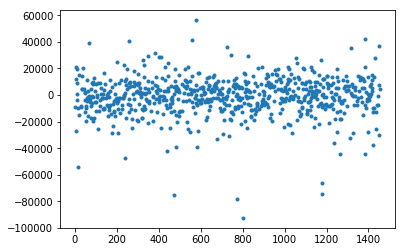

In [312]:
plt.plot((np.expm1(arpredict))-np.expm1(ytest), '.')

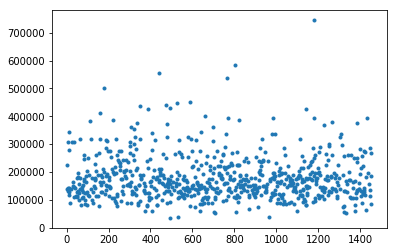

In [313]:
plt.plot((np.expm1(ytest)), '.')

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

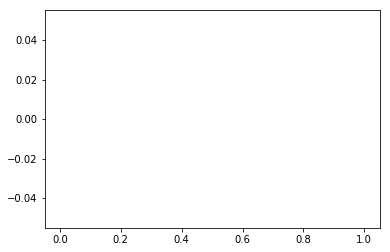

In [314]:
plt.hist(Xtest[abs(arpredict - ytest.values) > trsh]['OverallQual'])

In [315]:
ytest[abs(arpredict - ytest.values) > 100000]

Series([], Name: SalePrice, dtype: float64)

In [316]:
testDataTemp = testData.drop(['Id'], 1)
arpredict = averagingC.predict(testDataTemp)
arpredict = np.expm1(arpredict)
ypredict = pd.DataFrame({'Id': testData['Id'], 'SalePrice':arpredict})
ypredict.to_csv('../predictions.csv', index = False)

In [317]:
ypredict.head()

,Id,SalePrice
0,1461,122098.579
1,1462,162453.402
2,1463,187896.518
3,1464,194799.852
4,1465,196144.476


In [318]:
yold = pd.read_csv('../predictions120.csv')

In [319]:
yold.head()

,Id,SalePrice
0,1461,123047.755
1,1462,160636.957
2,1463,188751.986
3,1464,190415.651
4,1465,193684.515


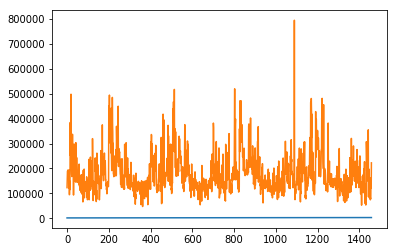

In [320]:
plt.plot(yold)

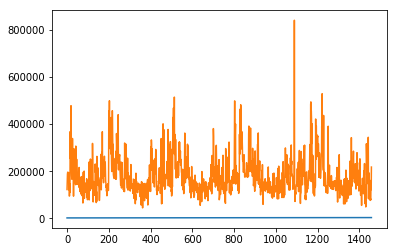

In [321]:
plt.plot(ypredict)

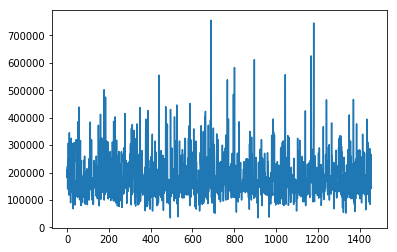

In [322]:
plt.plot(np.expm1(trData['SalePrice']))

In [323]:
print(metrics.mean_squared_log_error(yold, ypredict)**0.5)


0.0206750283671
